In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from WARP.visualization import set_mplstyle
set_mplstyle()
from WARP.visualization import save_figure

import pickle

In [3]:
p = '/nrs/ahrensraverfish/hesselinkl/RAVERFISH/'
p2 = '/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/'

### Load data

#### Load fish data

In [4]:
from WARP.data_loading import load_WARP_data
from WARP.data_loading import filter_fish_data
from WARP.data_loading import add_subtypes_to_fish_data

fish_inspect = [59, 63, 71]

# fish_data = load_WARP_data(data_path=p+'data',
#                             filter_genes=['pitx2'], 
#                             fish_list=fish_inspect)

# fish_data = add_subtypes_to_fish_data(fish_data, ignore_genes_list=['cfos'])

# fish_data = filter_fish_data(fish_data, 
#                              filter_in_out_of_plane=True, 
#                              filter_nan_traces=True, 
#                              filter_zero_traces=True)

# with open(p + 'fish_data.pkl', 'wb') as f:
#     pickle.dump(fish_data, f)

with open(p + 'fish_data.pkl', 'rb') as f:
    fish_data = pickle.load(f)

#### Load precomputed LCD data

LCD data should be downloaded or computed using `/notebooks/calculate_LCD.ipynb`

In [5]:
import pickle
from tqdm.auto import tqdm

filter_genes = ['cx43', 'pitx2', 'cfos']

with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/data/LCD_data_new.pkl', 'rb') as f:
    LCD_data = pickle.load(f)

with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/data/LCD_data_time.pkl', 'rb') as f:
    LCD_data_time = pickle.load(f)

# with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/LCD_data_min2500_max15000.pkl', 'rb') as f:
#     LCD_data_large = pickle.load(f)

for fish_n in tqdm(fish_inspect):
    for paradigm in LCD_data.keys():
        for gene in LCD_data[paradigm][fish_n].keys():
            try:
                LCD_data[paradigm][fish_n][gene]['observed_stats']['distance'][20]['vals_time_full'] = LCD_data_time[paradigm][fish_n][gene]['observed_stats']['distance'][20]['vals_time_full']
            except:
                pass
        #     LCD_data['visrap'][fish_n][gene]['observed_stats']['distance'][20]['vals_time_full'] = None
            # LCD_data['visrap'][fish_n].update(LCD_data_vglut_gad['visrap'][fish_n])

# with open('/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/LCD_data.pkl', 'wb') as f:
#     pickle.dump(LCD_data, f)

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
filter_genes = ['cx43', 'pitx2', 'cfos']

# Filter out genes
for paradigm in LCD_data.keys():
    for fish_n in fish_inspect:
        gene_list = list(LCD_data[paradigm][fish_n].keys())
        for gene in gene_list:
            if gene in filter_genes:
                del LCD_data[paradigm][fish_n][gene]

### Statistics

In [7]:
from WARP.lcd_statistics import compute_pvals
from WARP.lcd_statistics import merge_LCD_dicts

LCD_data = compute_pvals(
    LCD_data=LCD_data,
    fish_inspect=fish_inspect,
    alpha=0.05,
    alternative="two-sided",
    paradigms=None,
    mask_types=("distance", "region"),)


LCD_merged = merge_LCD_dicts(
    LCD_data,
    fish_inspect=fish_inspect,
    alpha=0.05,
    paradigms=None,              # or e.g. ['visrap']
    mask_types=("distance", "region"),
)

## Figure panels

### Figure S12B

In [ ]:
from WARP.lcd_utils import compute_neighbor_correlation_vs_radius

radii = np.arange(5, 55, 5)

avg_corr_radii, neigh_radii = compute_neighbor_correlation_vs_radius(
    fish_data=fish_data,
    fish_inspect=fish_inspect,
    stim_key="visrap",
    radii=radii,
    coords_key="cell_centers_zb",
    traces_key="visrap",
    subsample=1
)

In [ ]:
from WARP.visualization import plot_neighbor_correlation_vs_radius

fig = plot_neighbor_correlation_vs_radius(
    average_correlations_radii=avg_corr_radii,
    neighbors_radii=neigh_radii,
    stim_type="visrap",
    source_key="fish_concat",
    color_corr='k',
    color_neigh='firebrick',
    chosen_radius=15,
    figsize=(2.5, 1.2),
    save_figure=save_figure,
    save_dir=None,
    save_name=None,
)

save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_S12/",
            "Figure_S12B",
            dpi=1000, 
            pad_inches=0)

### Figure S12C

In [11]:
# Get values distributions for each gene
LCD_vals = {paradigm: {gene: d['observed_stats']['distance'][20]['vals'] for gene, d in LCD_merged[paradigm].items()}
            for paradigm in LCD_merged.keys()}
LCD_pvals_uncorr = {paradigm: {gene: d['p_vals']['distance'][20]['median']['standard'] for gene, d in LCD_merged[paradigm].items()} 
             for paradigm in LCD_merged.keys()}
LCD_pvals = {paradigm: {gene: d['p_vals']['distance'][20]['median']['corrected'] for gene, d in LCD_merged[paradigm].items()} 
             for paradigm in LCD_merged.keys()}
LCD_vals = {paradigm: {gene: vals[~np.isnan(vals[:, 0])] for gene, vals in LCD_vals[paradigm].items()} 
            for paradigm in LCD_vals.keys()}

In [16]:
for paradigm in LCD_vals.keys():
    genes = np.sort(list(LCD_pvals[paradigm].keys()))
    pvals = [LCD_pvals[paradigm][k] for k in genes]
    pvals_uncorr = [LCD_pvals_uncorr[paradigm][k] for k in genes]
    
    import pandas as pd
    
    df = pd.DataFrame({
        "gene": genes,
        "p_value_uncorr": pvals_uncorr,
        "p_value": pvals
    })
    
    df.to_excel(f"genes_pvals_{paradigm}.xlsx", index=False)

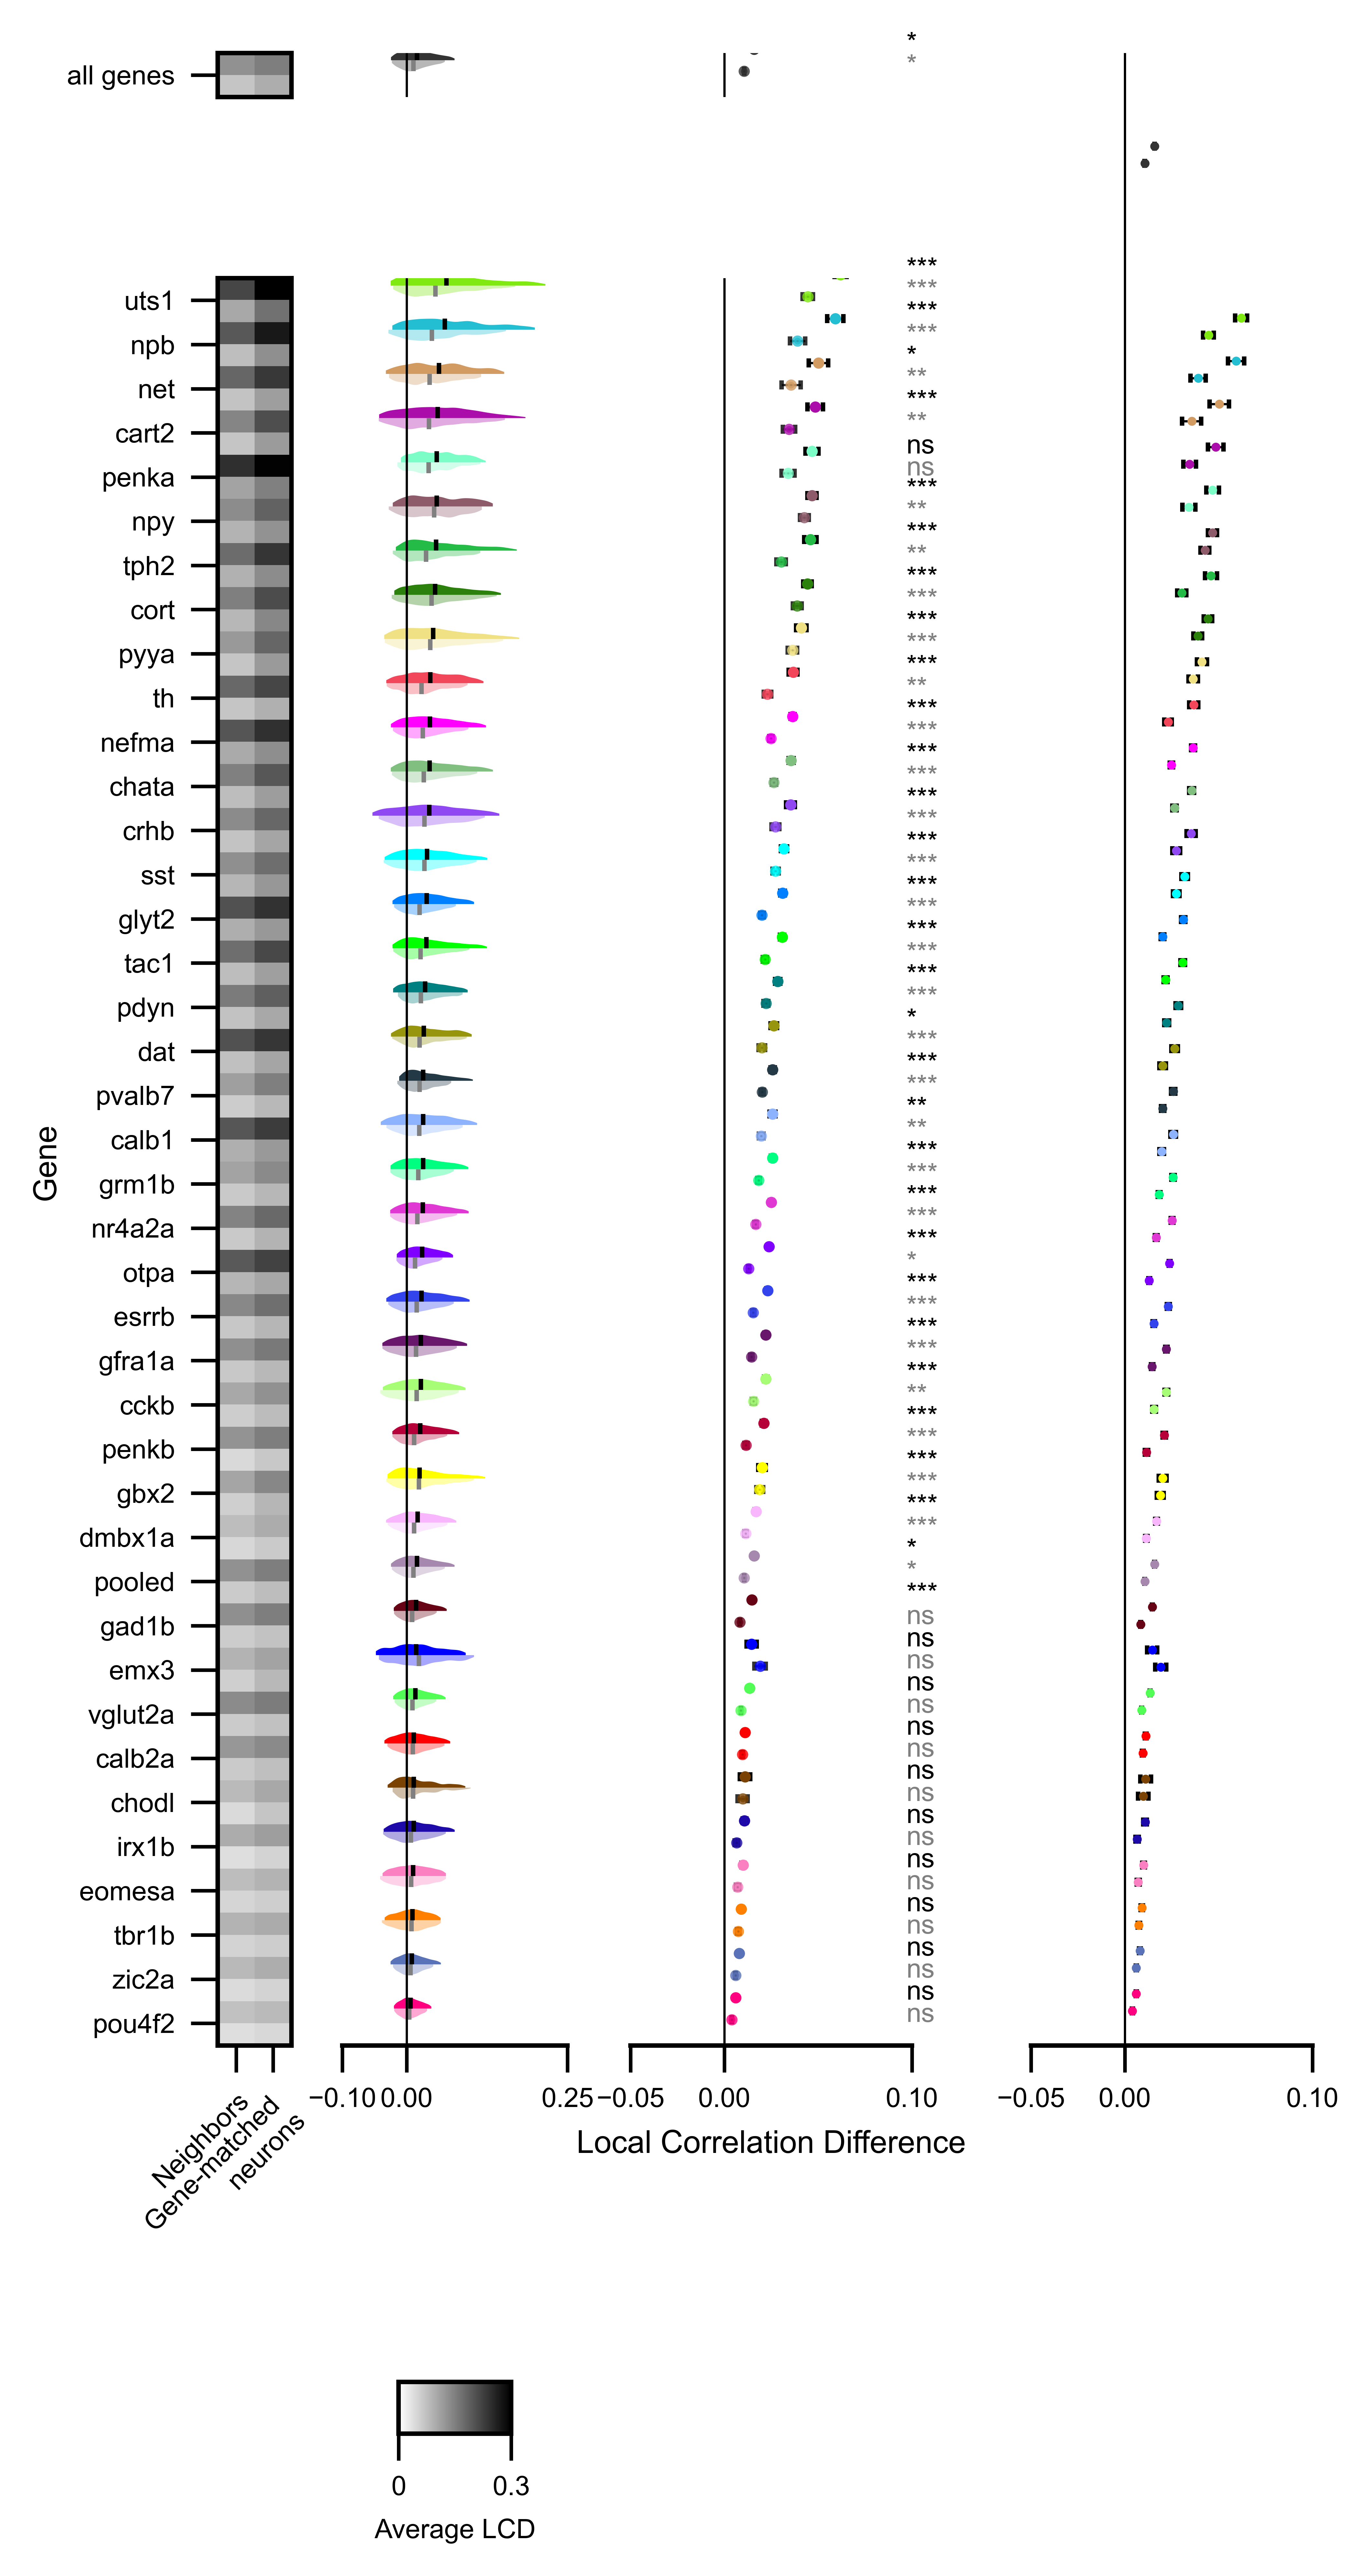

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_S12/


In [33]:
from WARP.visualization import plot_lcd_distributions
from WARP.visualization import make_cmap_dict

sort_inds = np.argsort([np.nanmedian(v[:, 0]) for v in LCD_vals['visrap'].values()])
LCD_color_dict = make_cmap_dict(LCD_data[paradigm][fish_n].keys(), sort_inds=sort_inds)

fig = plot_lcd_distributions(
    lcd_vals=LCD_vals['visrap'],
    lcd_pvals=LCD_pvals['visrap'],
    lcd_vals2=LCD_vals['random'],
    lcd_pvals2=LCD_pvals['random'],
    color_dict=LCD_color_dict,
    highN=len(LCD_vals['visrap'].keys()),
    lowN=0,
    include_pooled_row=True,
    show_all_genes=False,
    save_figure=False,
    save_dir='',
    save_name='',
    filter_percentile=15,
    bw_method=.2
)

save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_S12/",
            "Figure_S12C",
            dpi=1000, 
            pad_inches=0.0)

In [35]:
a = .05
significant = [p < a for g, p in LCD_pvals['visrap'].items()]

print(f'{sum(significant)-1}/{len(significant)-1} genes were significant under permutation for paradigm visrap')


a = .05
significant = [p < a for g, p in LCD_pvals['random'].items()]

print(f'{sum(significant)-1}/{len(significant)-1} genes were significant under permutation for paradigm random')

29/39 genes were significant under permutation for paradigm visrap
28/39 genes were significant under permutation for paradigm random


In [41]:
print(f"P value pooled visrap: {LCD_pvals['visrap']['pooled']}")
print(f"P value pooled random: {LCD_pvals['random']['pooled']}")

P value pooled visrap: 0.018399811283986833
P value pooled random: 0.02219464415749582


### Figure S12 Clustering

In [17]:
from WARP.lcd_clustering_utils import run_multiscale_lcd_clustering_across_genes
from WARP.lcd_clustering_utils import filter_supported_clusters
from WARP.lcd_clustering_utils import filter_supported_clusters_by_gene
from WARP.lcd_statistics import compute_cluster_pvals_all_clusters

# Run clustering across genes
cluster_dict, cluster_dict_by_gene = (
    run_multiscale_lcd_clustering_across_genes(
        LCD_data=LCD_data,
        fish_data=fish_data,
        fish_inspect=fish_inspect,
        distance_bin=20,
        target_cluster_size=10,
        n_neighbors=25,
        min_cluster_size=25,
        min_frac_per_fish=0.5,
        random_state=0,
        cluster_mode="leiden",
        mode_kwargs={"resolution": .1},  # optional; omit to use heuristic search
    )
)


# Compute cluster p-values using the precomputed neuron-wise permutations
cluster_dict, cluster_pooled_pval = compute_cluster_pvals_all_clusters(
    cluster_dict=cluster_dict,
    LCD_data=LCD_data,
    fish_data=fish_data,
    fish_inspect=fish_inspect,
    stim_keys=["random", "visrap"],
    mask_type="distance",
    mask=20,
    alternative="two-sided",
    center=None,
    alpha=0.05,
)


cluster_dict_supported = filter_supported_clusters(cluster_dict)
clusters_by_gene_supported = filter_supported_clusters_by_gene(cluster_dict_by_gene)

print("Supported clusters:", len(cluster_dict_supported))

Running LCD clustering across genes:   0%|          | 0/40 [00:00<?, ?it/s]

Skipping gene pooled: No neurons found for gene pooled in the specified fish.
Supported clusters: 207


In [19]:
for paradigm in ['visrap', 'random']:
    lcd_pvals_uncorr = {k: v['cluster_pval'][paradigm]['p_value'] for k, v in cluster_dict_supported.items()}
    lcd_pvals = {k: v['cluster_pval'][paradigm]['p_value_corr'] for k, v in cluster_dict_supported.items()}
    
    for paradigm in LCD_vals.keys():
        genes = np.sort(list(LCD_pvals[paradigm].keys()))
        pvals = [LCD_pvals[paradigm][k] for k in genes]
        pvals_uncorr = [LCD_pvals_uncorr[paradigm][k] for k in genes]
        
        import pandas as pd
        
        df = pd.DataFrame({
            "gene": lcd_pvals_uncorr.keys(),
            "p_value_uncorr": lcd_pvals_uncorr.values(),
            "p_value": lcd_pvals.values()
        })
        
        df.to_excel(f"cluster_pvals_{paradigm}.xlsx", index=False)

#### Figure S12D

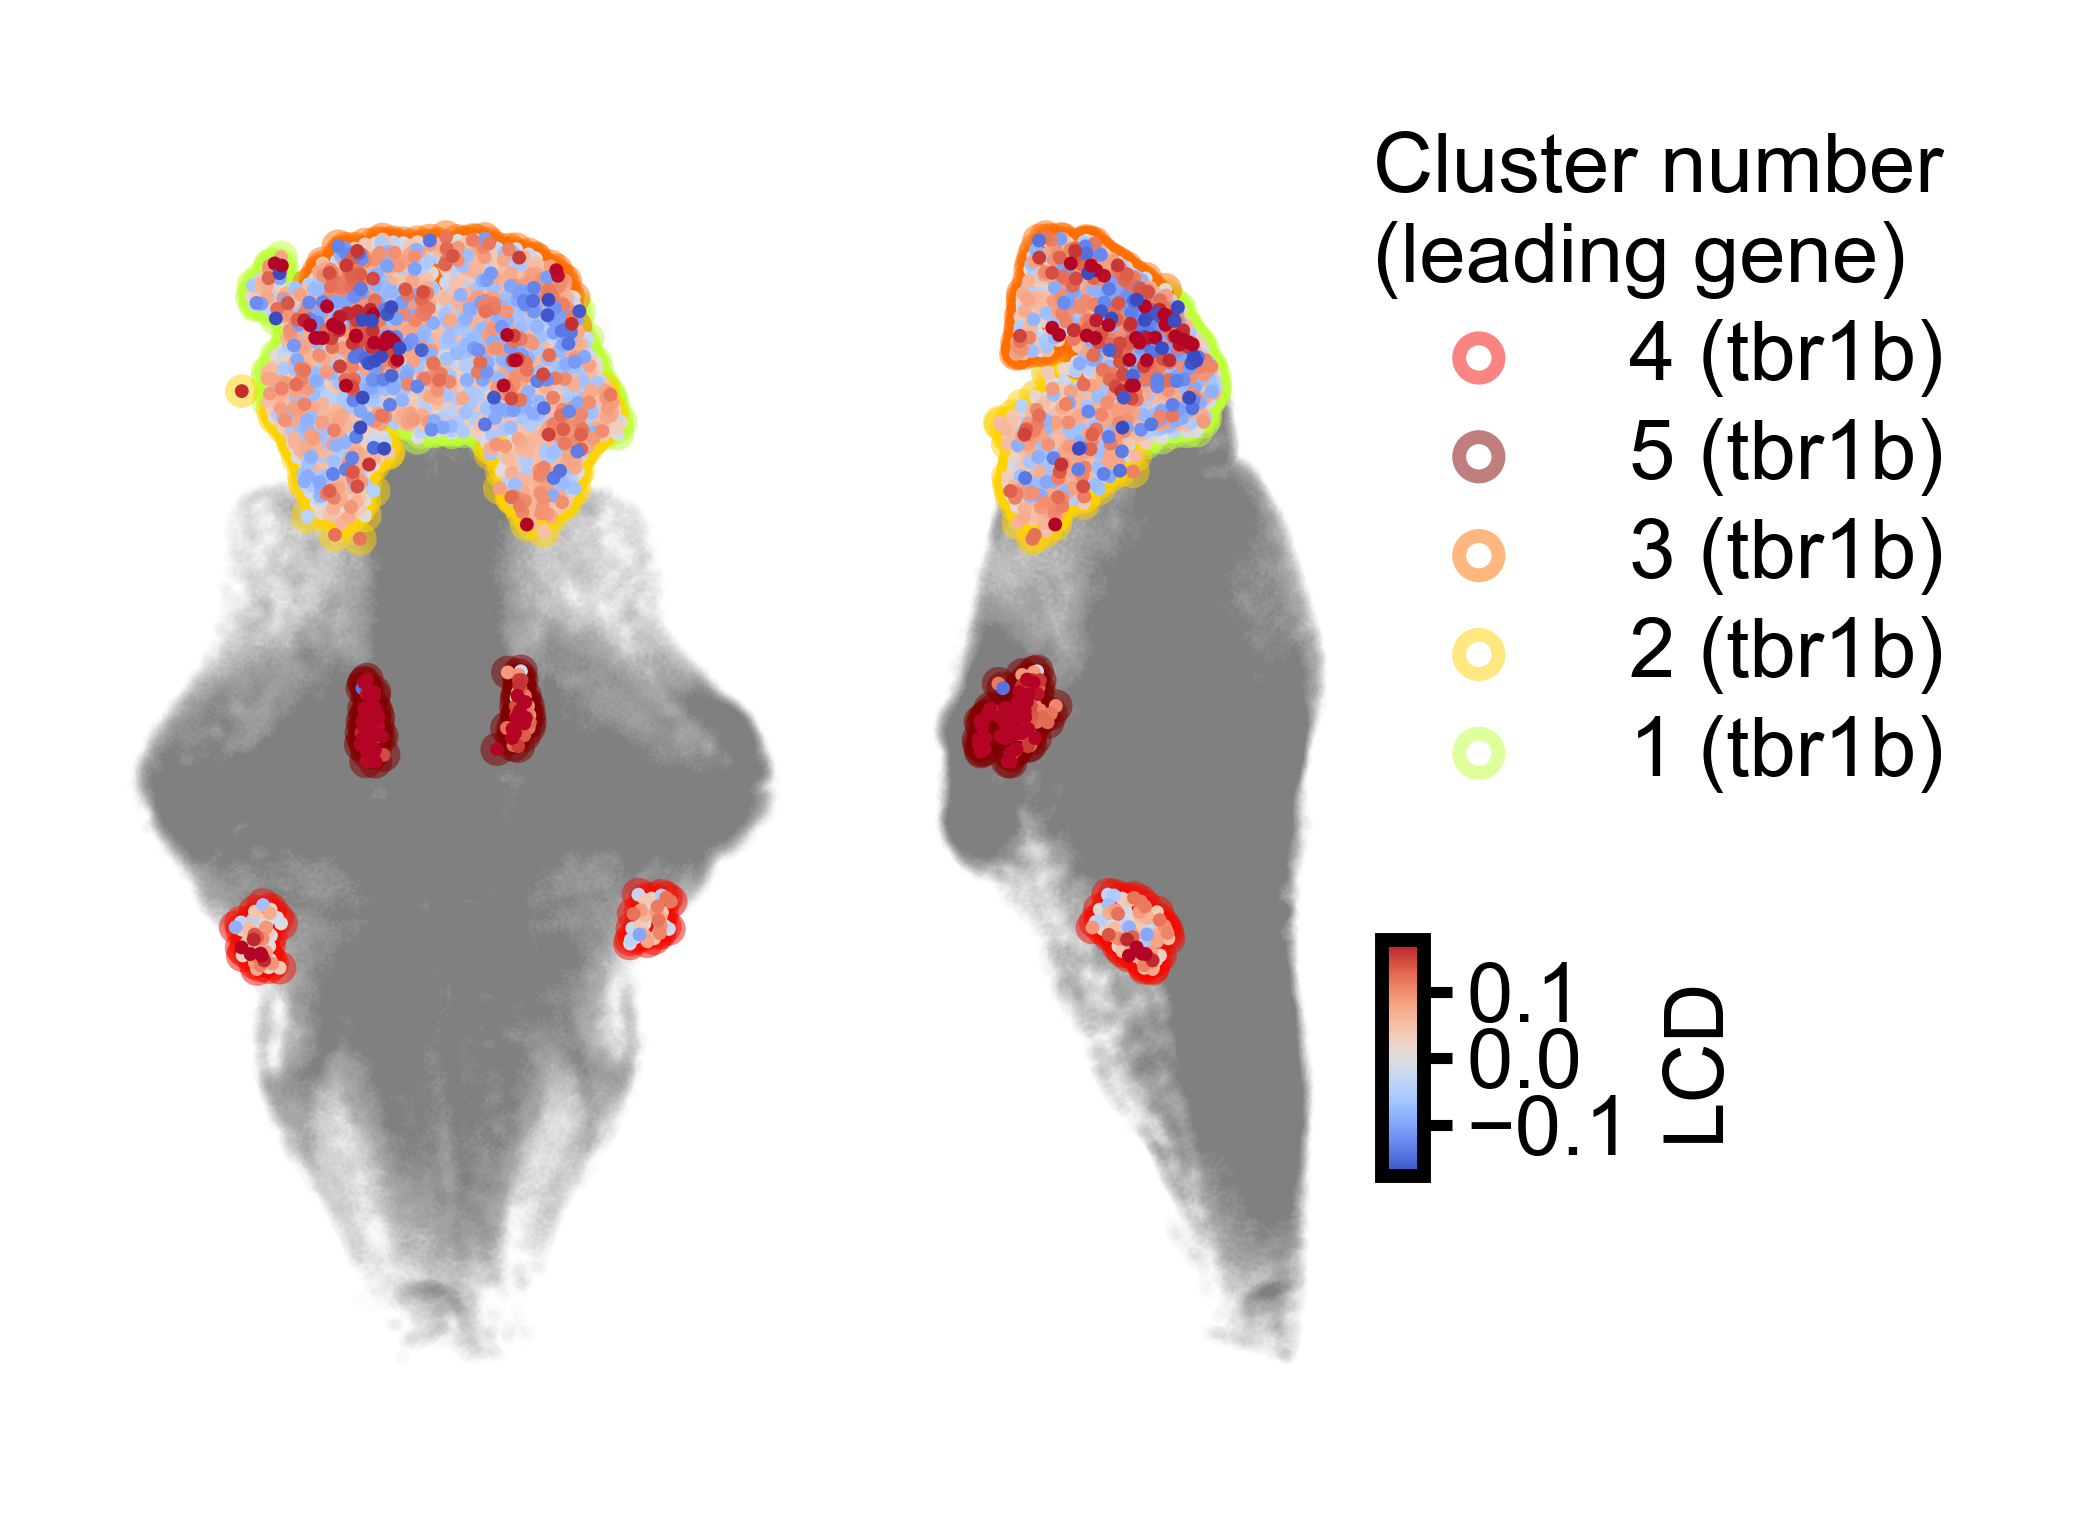

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_S12/


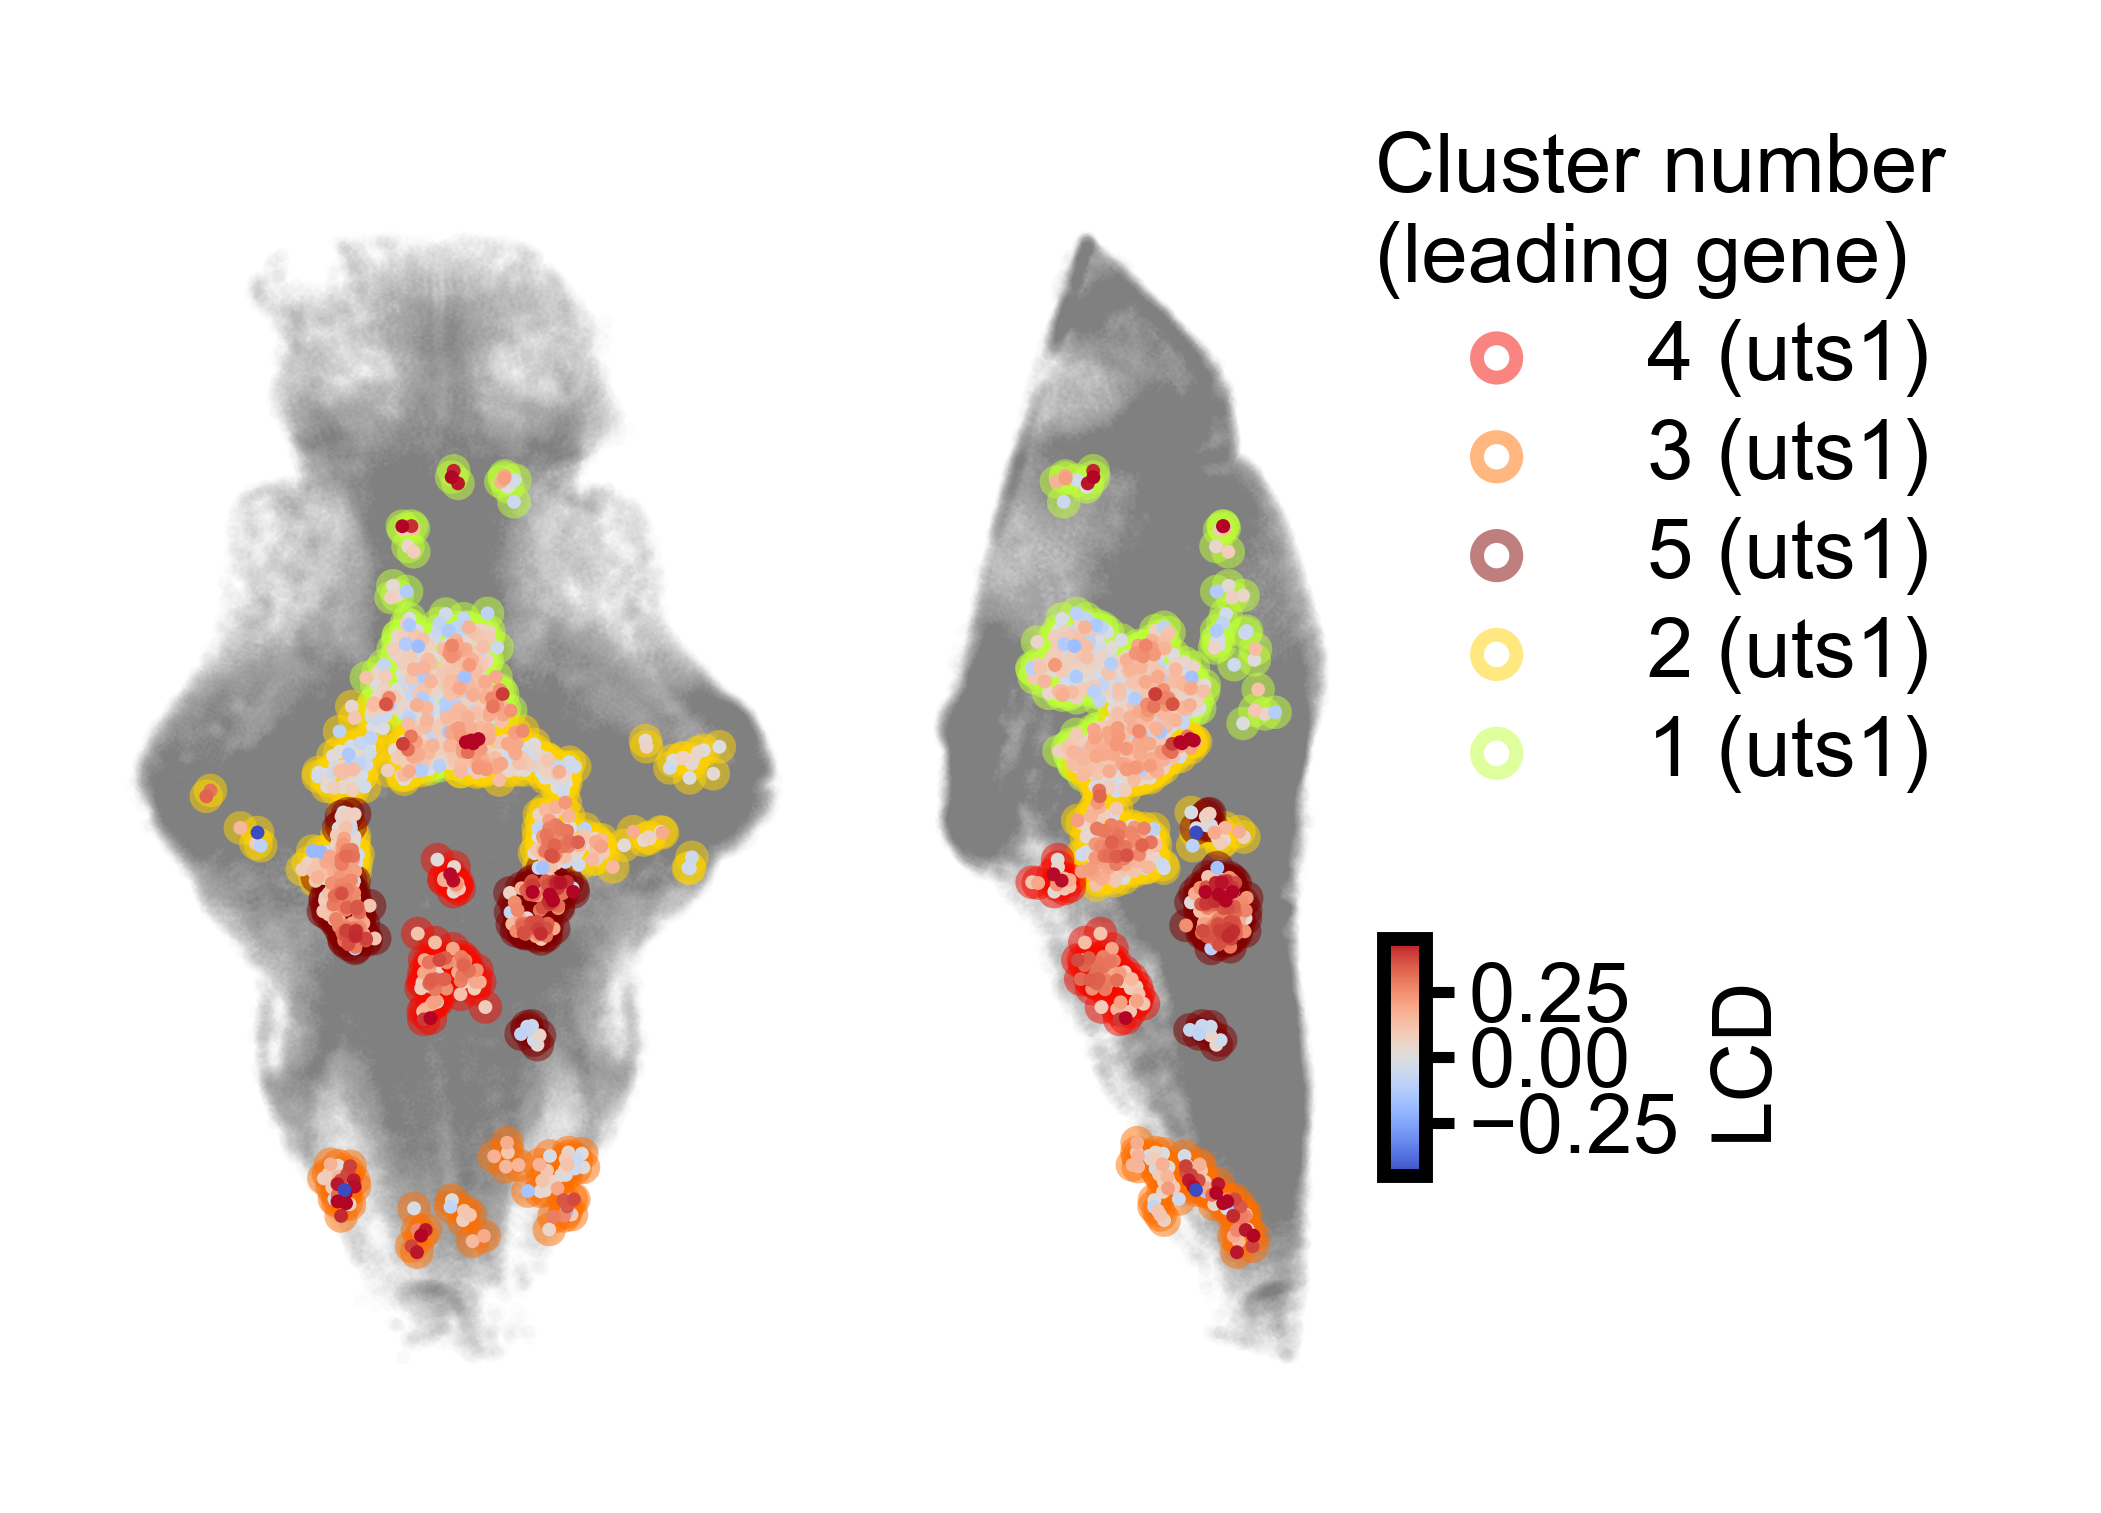

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_S12/


In [41]:
from WARP.visualization import plot_extreme_clusters_brain_map
from WARP.visualization import compute_lcd_color_dict

highN = 12
lowN = 3

# cell_centers_all = np.concatenate([fish_data[fish_n]['cell_centers_data']['cell_centers_zb'] for fish_n in fish_inspect], axis=0)
cell_centers_all = fish_data[63]['cell_centers_data']['cell_centers_zb']

for gene in ['tbr1b', 'uts1']:
# for gene in cluster_dict_by_gene_supported.keys():

    color_name_order_dict = compute_lcd_color_dict(
        cluster_dict=clusters_by_gene_supported[gene],
        highN=len(list(clusters_by_gene_supported[gene].keys())),
        lowN=0,
        color_mode="discrete",      # or "median_highlow", "median_all", "dict"
        median_cmap="jet",
        base_color_dict=None,       # or your gene color map if color_mode="dict"
    )
        
    fig_ext, axes_ext = plot_extreme_clusters_brain_map(
        cell_centers_all=cell_centers_all,
        cluster_dict=clusters_by_gene_supported[gene],
        color_dict=color_name_order_dict,
        which="both",
        fill_mode="value",
        proj_axes=((1, 2), (0, 2)), 
        s=2,
        sort_mode='by_value', 
        alpha_inner=1,
        alpha_outer=.5,
        alpha_bg=0.025,
        sort_ascending=True, 
        # val_vmin=-.25, 
        # val_vmax=.25,
        show_legend=True,
        figsize=(1.9, 1.6),
    )
    plt.show()
    
    save_figure(fig_ext, 
                p2+"/WARP/figures/Figure_Panels/figure_S12/",
                f"Figure_S12D_{gene}",
                dpi=1000,
                pad_inches=0)


#### Figure S12E

In [42]:
# from WARP.visualization import plot_cluster_lcd_time_heatmaps

# order_keys = {d['order']: k for k, d in color_name_order_dict.items()}

# for order_key in np.arange(1, 16):
#     fig = plot_cluster_lcd_time_heatmaps(
#         cluster_dict=cluster_dict_supported,
#         cluster_id=order_keys[order_key],
#         sample_rate_hz=2.0,
#         xtick_step=50,
#         cmap="coolwarm",
#         figsize=(6, 6),
#         fish_data=fish_data,
#         fish_for_stim=59,
#         stim_cmap='tab10',
#         show_stim_axis=True,
#         stim_key='random'
#     )
#     plt.show()

[plot_cluster_lcd_time_heatmaps] Cluster contains multiple fish [59 63 71], using '59' for stimulus axis / averaging.


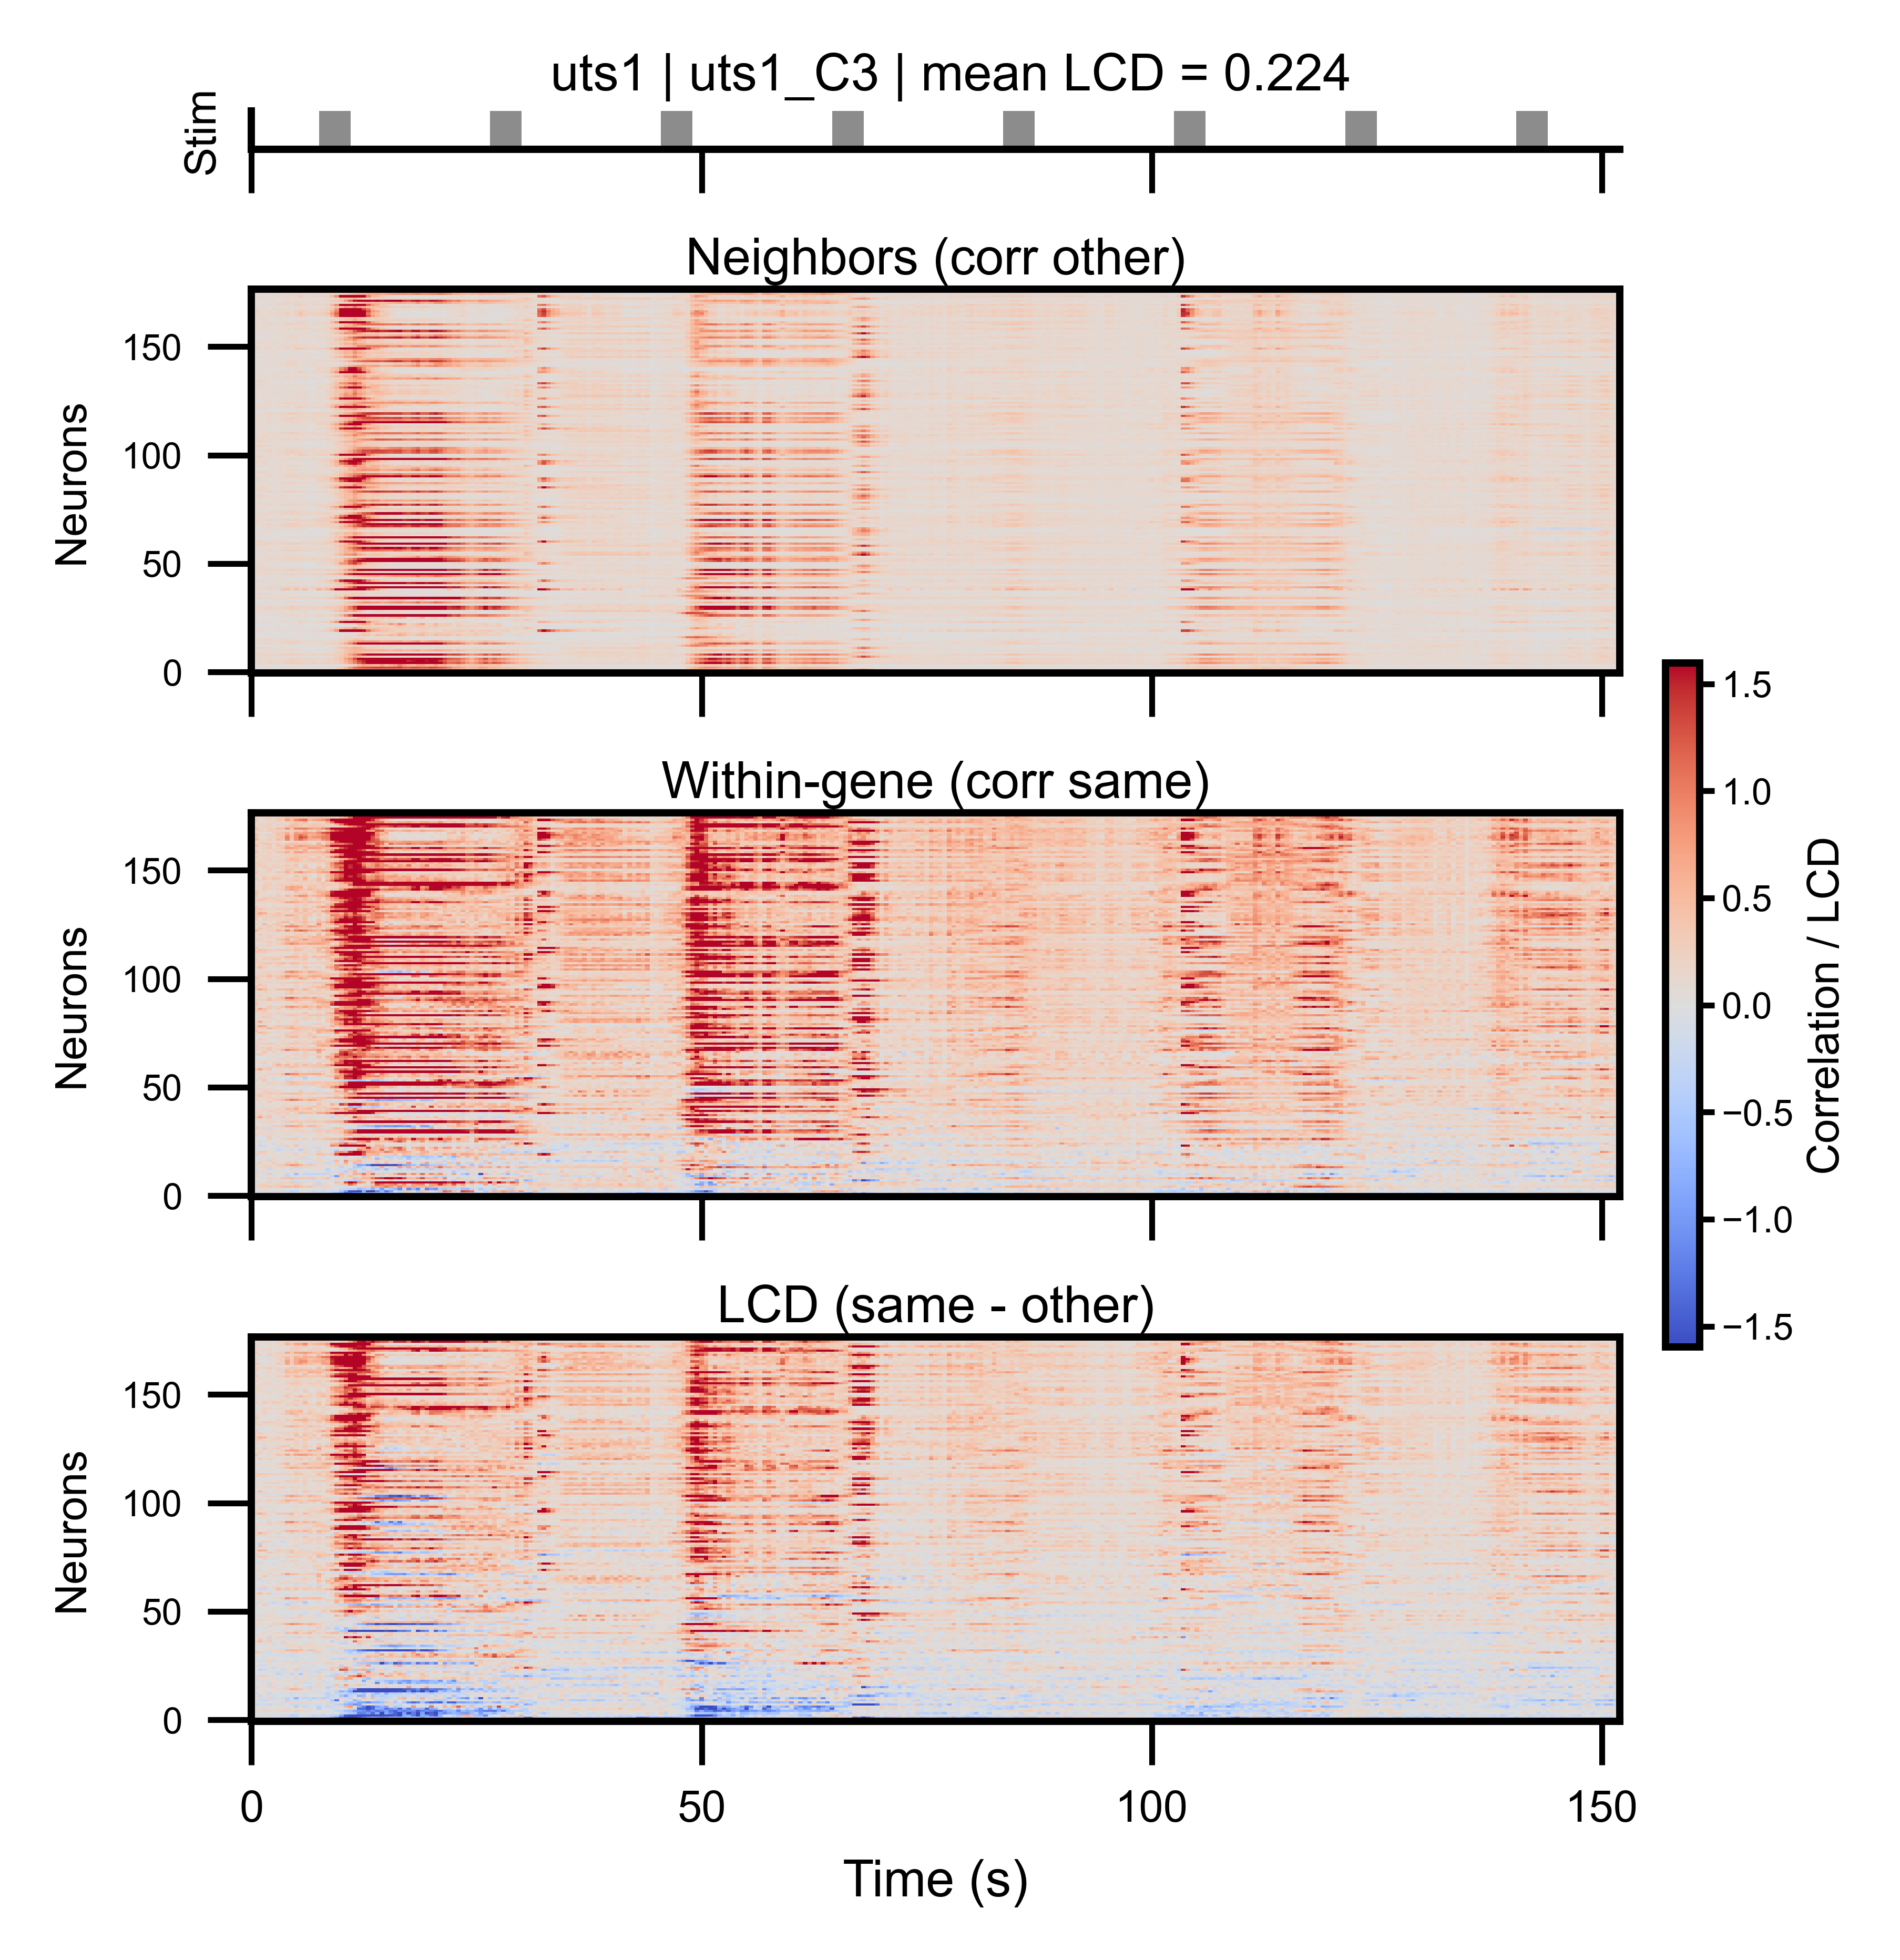

Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_S12/


In [43]:
from WARP.visualization import plot_cluster_lcd_time_heatmaps

highN = 12
lowN = 3

color_name_order_dict = compute_lcd_color_dict(
    cluster_dict=cluster_dict_supported,
    highN=highN,
    lowN=lowN,
    color_mode="discrete",      # or "median_highlow", "median_all", "dict"
    median_cmap="coolwarm",
    base_color_dict=None,       # or your gene color map if color_mode="dict"
    stim_key='visrap'
)

order_keys = {d['order']: k for k, d in color_name_order_dict.items()}

for order_key in np.arange(15, 16):
    fig = plot_cluster_lcd_time_heatmaps(
        cluster_dict_supported,
        cluster_id=order_keys[order_key],
        fish_data=fish_data,
        stim_key="visrap",
        stim_cmap='tab10',
        figsize=(3.5, 3.5),
        show_stim_axis=True,
        use_stim_averages=True,
        pre_duration=15,
        stim_duration=7,
        post_duration=16,
    )
    plt.show()

    if order_key == 15:
        save_figure(fig, 
            p2+"/WARP/figures/Figure_Panels/figure_S12/",
            "Figure_S12E",
            dpi=1000, 
            pad_inches=0)

#### Figure S12F

In [44]:
from WARP.lcd_clustering_utils import compute_cluster_stim_lcd_stats

cluster_stim_stats = compute_cluster_stim_lcd_stats(
    cluster_dict=cluster_dict_supported,
    fish_data=fish_data,
    stim_key="visrap",
    pre_duration=15,
    stim_duration=7,
    post_duration=16,
    component="lcd",  # or "same" / "other"
)

/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/WARP/stimulus_response_utils.py:117: RuntimeWarning: Mean of empty slice
  avg_stim_responses = np.nanmean(stim_responses, axis=2)
/groups/ahrens/home/hesselinkl/anaconda3/envs/warp/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/WARP/lcd_clustering_utils.py:1706: RuntimeWarning: All-NaN slice encountered
  epoch_means_f[:, :, e_idx] = np.nanmedian(avg_responses[:, :, idxs], axis=2)


/groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH/WARP/WARP/visualization.py:4727: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Succesfully saved figure to /groups/ahrens/ahrenslab/Luuk/projects/RAVERFISH//WARP/figures/Figure_Panels/figure_S12/


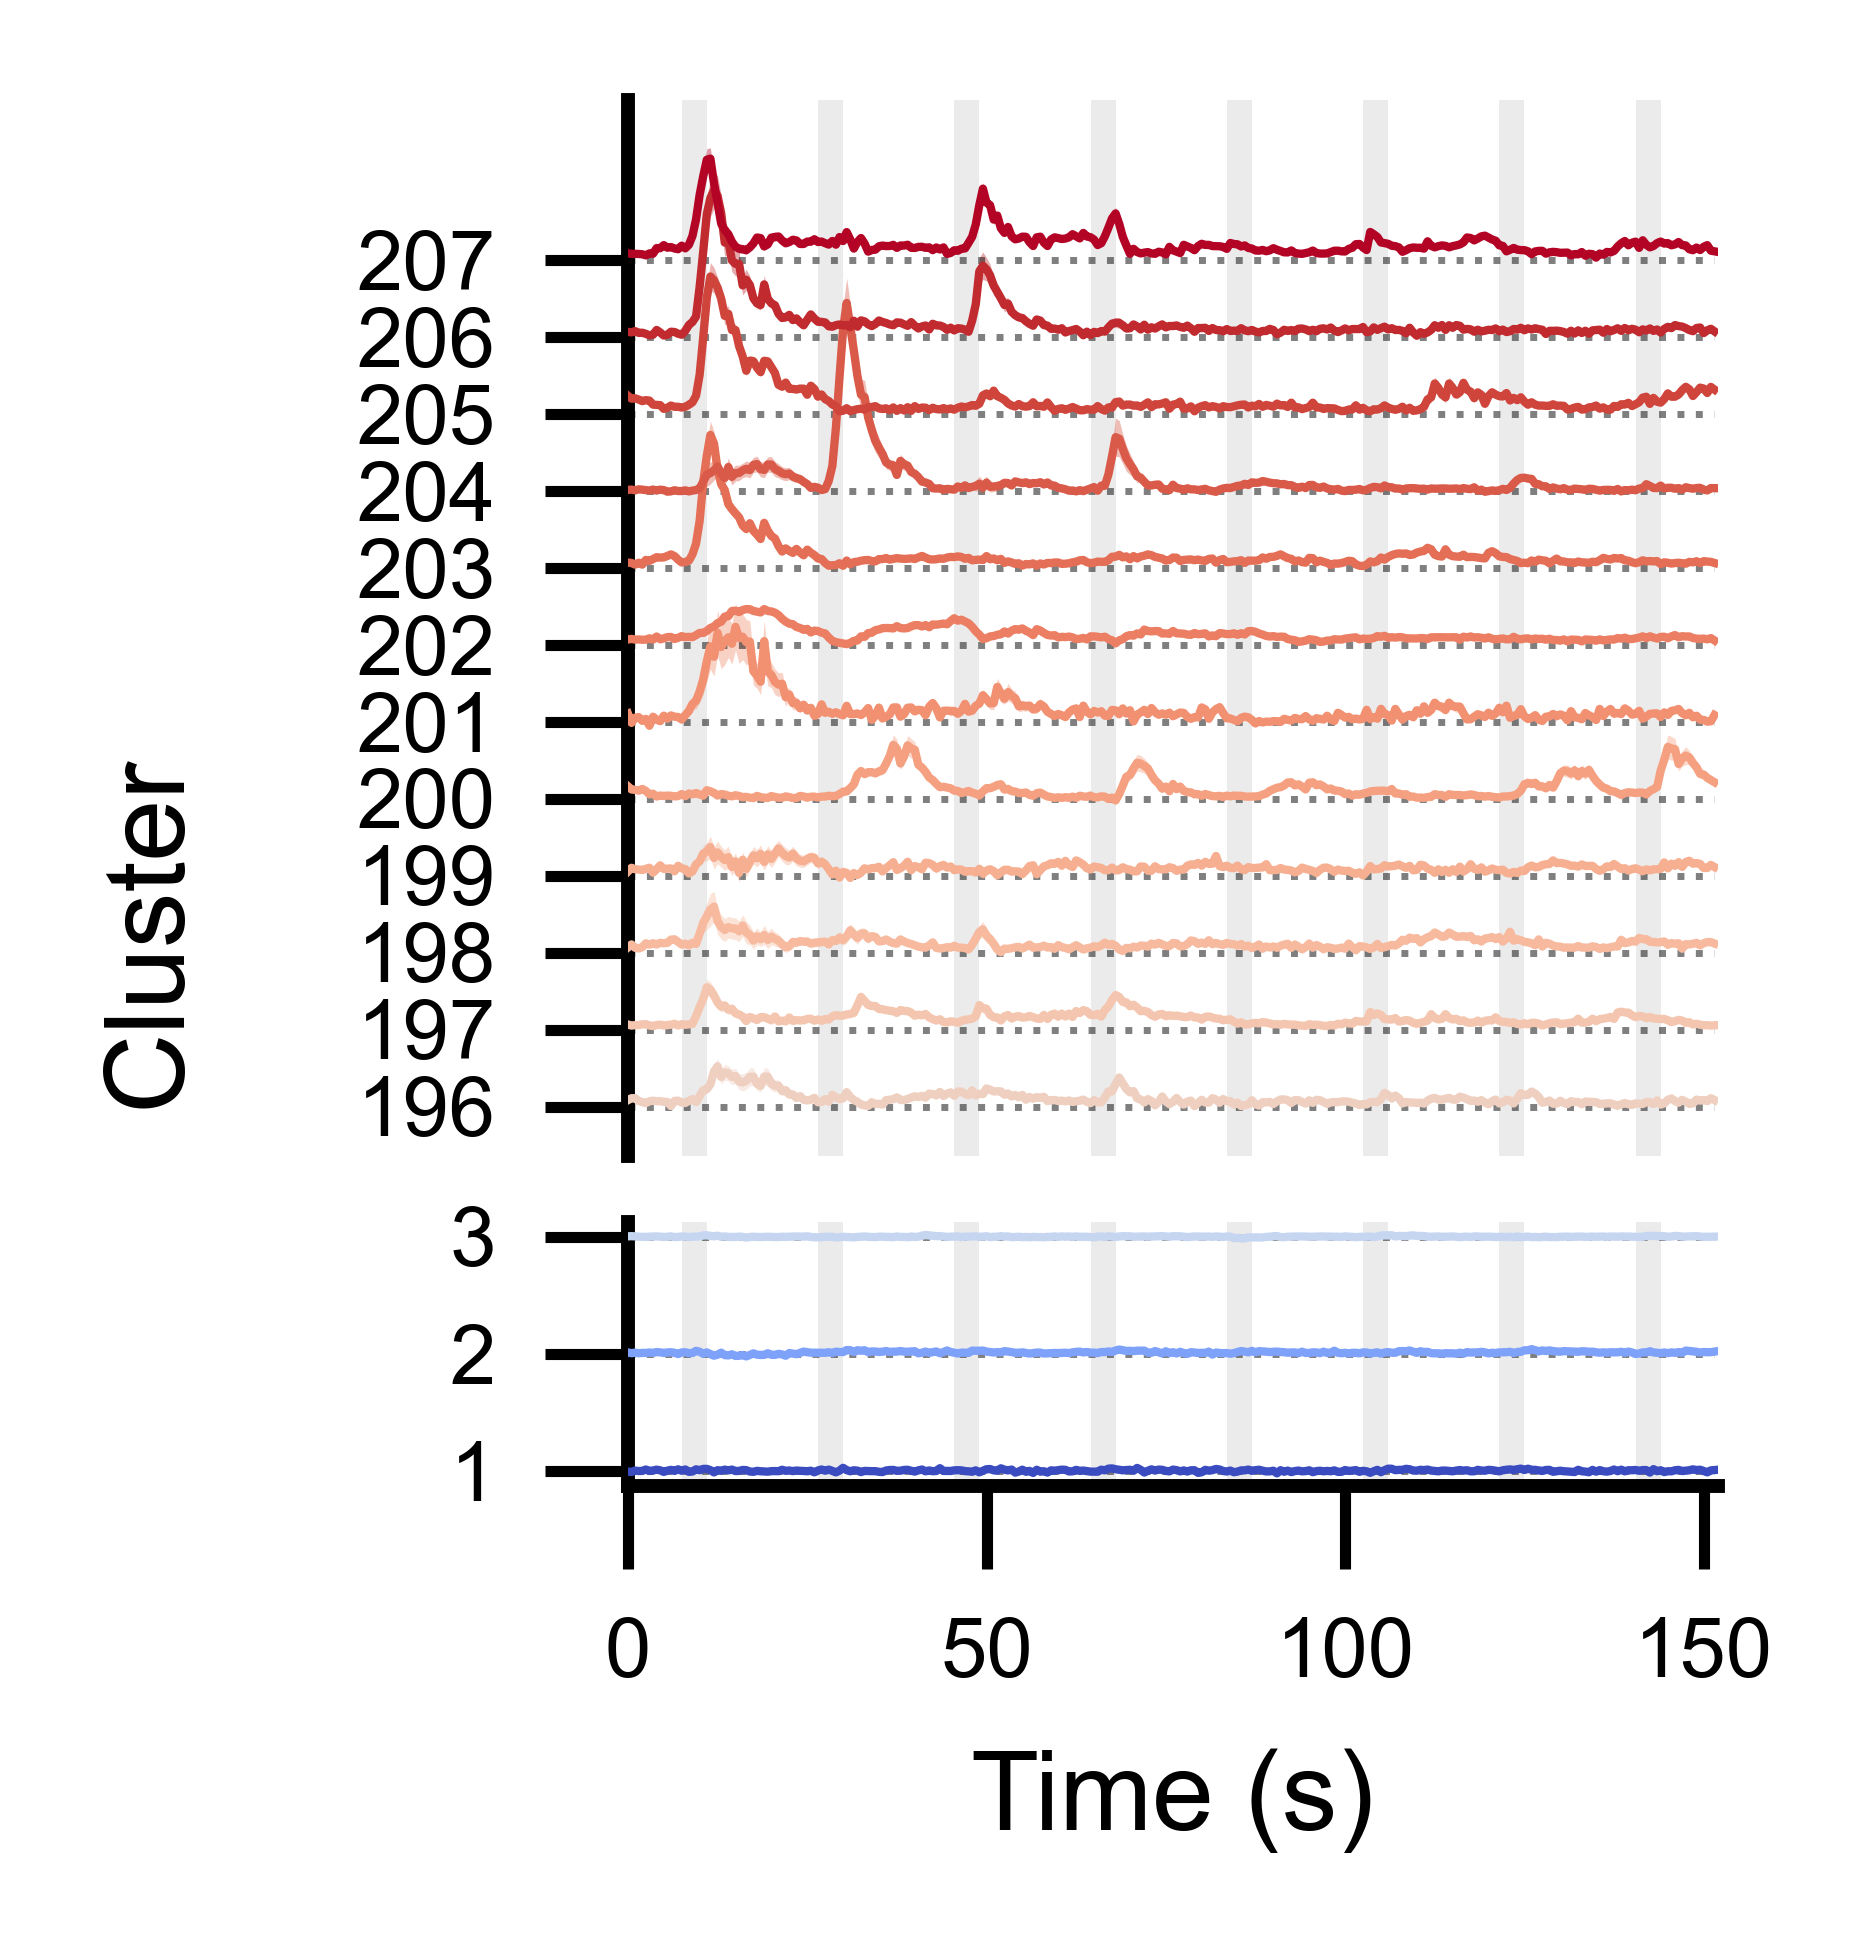

In [45]:
from WARP.visualization import plot_cluster_stim_lcd_traces

fig = plot_cluster_stim_lcd_traces(
    cluster_dict=cluster_dict_supported,
    color_dict=color_name_order_dict,
    cluster_stim_stats=cluster_stim_stats,
    which="both",      # "both", "high", "low"
    lowN=3,
    highN=12,
    min_cells_per_cluster=5,
    sample_rate_hz=2.0,
    xtick_step=100,
    offset_step=1,
    figsize=(1.6, 1.8),
    save_dir=None,
    use_order_label=False
)

save_figure(fig, 
    p2+"/WARP/figures/Figure_Panels/figure_S12/",
    "Figure_S12F",
    dpi=1000, 
    pad_inches=0)

#### Figure S12G

In [ ]:
from WARP.visualization import plot_cluster_behavior_corr_split_violins

fig = plot_cluster_behavior_corr_split_violins(
    cluster_dict=cluster_dict_supported,
    color_dict=color_name_order_dict,
    fish_data=fish_data,
    fish_inspect=fish_inspect,
    stim_keys=["visrap", "random"],
    which="both",
    lowN=3,
    highN=12,
    bw_method=.3,
    figsize=(1.6, 2),
    use_order_label=False
)

save_figure(fig, 
    p2+"/WARP/figures/Figure_Panels/figure_S12/",
    "Figure_S12G",
    dpi=1000, 
    pad_inches=0)

In [21]:
from WARP.lcd_utils import compute_lcd_spontaneous_vs_visstim_stats
from WARP.visualization import plot_lcd_spontaneous_vs_visstim

stats = compute_lcd_spontaneous_vs_visstim_stats(
    LCD_data,
    fish_inspect=fish_inspect,
    mask_type="distance",
    mask=20,
    spont_key="random",
    engaged_key="visrap",
)

fig = plot_lcd_spontaneous_vs_visstim(
    stats,
    N_text=5,
    cmap_dict=LCD_color_dict,
)

# save_figure(fig, 
#             p2+"/WARP/figures/Figure_Panels/figure_6/",
#             "Figure_6H",
#             dpi=1000, 
#             pad_inches=0)

Two-sided Wilcoxon Signed Rank Test. all genes, p<ε; npb, 1.670e-07; net, 4.986e-03; uts1, 4.394e-20; th, 2.653e-14; penka, 2.045e-09; cart2, 4.641e-08; tph2, 2.780e-18; npy, 7.118e-08; glyt2, 1.829e-44; otpa, 1.692e-152; nefma, 7.009e-53; grm1b, 7.440e-49; chata, 6.204e-28; crhb, 4.250e-06; penkb, 1.524e-32; esrrb, 3.026e-68; nr4a2a, 1.275e-58; gad1b, p<ε; gfra1a, 6.295e-40; irx1b, 8.747e-17; tac1, 2.378e-23; pvalb7, 1.765e-38; all genes, p<ε; pooled, p<ε; cort, 7.391e-04; pyya, 1.759e-05; cckb, 5.534e-15; sst, 4.207e-06; dmbx1a, 4.446e-22; vglut2a, p<ε; eomesa, 2.088e-07; calb1, 4.264e-04; gbx2, 9.936e-04; dat, 1.527e-03; zic2a, 1.673e-46; pou4f2, 9.836e-39; tbr1b, 2.220e-07; calb2a, 9.876e-12; pdyn, 6.232e-03; chodl, 1.725e-01; emx3, 1.031e-03;

Two-sided Wilcoxon Signed Rank Test, Bonferroni-corrected. all genes, p<ε; npb, 6.847e-06; net, 2.044e-01; uts1, 1.802e-18; th, 1.088e-12; penka, 8.385e-08; cart2, 1.903e-06; tph2, 1.140e-16; npy, 2.919e-06; glyt2, 7.500e-43; otpa, 6.938e-15

NameError: name 'LCD_color_dict' is not defined

In [27]:
stats['gene_names_tot']

['calb1',
 'calb2a',
 'cart2',
 'cckb',
 'chata',
 'chodl',
 'cort',
 'crhb',
 'dat',
 'dmbx1a',
 'emx3',
 'eomesa',
 'esrrb',
 'gad1b',
 'gbx2',
 'gfra1a',
 'glyt2',
 'grm1b',
 'irx1b',
 'nefma',
 'net',
 'npb',
 'npy',
 'nr4a2a',
 'otpa',
 'pdyn',
 'penka',
 'penkb',
 'pooled',
 'pou4f2',
 'pvalb7',
 'pyya',
 'sst',
 'tac1',
 'tbr1b',
 'th',
 'tph2',
 'uts1',
 'vglut2a',
 'zic2a']

In [36]:

genes = stats['gene_names_tot']
pvals = stats['p_vals_bonferroni']
pvals_uncorr =  stats['p_vals']
    
import pandas as pd

df = pd.DataFrame({
    "gene": genes,
    "p_value_uncorr": pvals_uncorr[:-1],
    "p_value": pvals[:-1]
})

df.to_excel(f"incr_pvals.xlsx", index=False)

In [32]:
len(genes)

40

In [35]:
genes

['calb1',
 'calb2a',
 'cart2',
 'cckb',
 'chata',
 'chodl',
 'cort',
 'crhb',
 'dat',
 'dmbx1a',
 'emx3',
 'eomesa',
 'esrrb',
 'gad1b',
 'gbx2',
 'gfra1a',
 'glyt2',
 'grm1b',
 'irx1b',
 'nefma',
 'net',
 'npb',
 'npy',
 'nr4a2a',
 'otpa',
 'pdyn',
 'penka',
 'penkb',
 'pooled',
 'pou4f2',
 'pvalb7',
 'pyya',
 'sst',
 'tac1',
 'tbr1b',
 'th',
 'tph2',
 'uts1',
 'vglut2a',
 'zic2a']

In [33]:
len(pvals)

41

In [34]:
pvals

array([1.74820329e-002, 4.04915438e-010, 1.90290767e-006, 2.26913690e-013,
       2.54383974e-026, 1.00000000e+000, 3.03029207e-002, 1.74262917e-004,
       6.26131936e-002, 1.82290150e-020, 4.22870668e-002, 8.56000803e-006,
       1.24069152e-066, 0.00000000e+000, 4.07356272e-002, 2.58081664e-038,
       7.50009490e-043, 3.05033806e-047, 3.58639422e-015, 2.87361309e-051,
       2.04438946e-001, 6.84664688e-006, 2.91854031e-006, 5.22695109e-057,
       6.93824285e-151, 2.55519186e-001, 8.38502019e-008, 6.25007715e-031,
       0.00000000e+000, 4.03257269e-037, 7.23586618e-037, 7.21113092e-004,
       1.72467201e-004, 9.75171795e-022, 9.10141271e-006, 1.08775150e-012,
       1.13961899e-016, 1.80153212e-018, 0.00000000e+000, 6.85969545e-045,
       0.00000000e+000])